In [1]:
# @title Import data from Kaggle

# IMPORTANT: RUN THIS CELL IN ORDER TO IMPORT YOUR KAGGLE DATA SOURCES
# TO THE CORRECT LOCATION (/kaggle/input) IN YOUR NOTEBOOK,
# THEN FEEL FREE TO DELETE THIS CELL.
# NOTE: THIS NOTEBOOK ENVIRONMENT DIFFERS FROM KAGGLE'S PYTHON
# ENVIRONMENT SO THERE MAY BE MISSING LIBRARIES USED BY YOUR
# NOTEBOOK.

import os
import sys
from tempfile import NamedTemporaryFile
from urllib.request import urlopen
from urllib.parse import unquote, urlparse
from urllib.error import HTTPError
from zipfile import ZipFile
import tarfile
import shutil

CHUNK_SIZE = 40960
DATA_SOURCE_MAPPING = ':https%3A%2F%2Fstorage.googleapis.com%2Fkaggle-competitions-data%2Fkaggle-v2%2F5407%2F868283%2Fbundle%2Farchive.zip%3FX-Goog-Algorithm%3DGOOG4-RSA-SHA256%26X-Goog-Credential%3Dgcp-kaggle-com%2540kaggle-161607.iam.gserviceaccount.com%252F20240326%252Fauto%252Fstorage%252Fgoog4_request%26X-Goog-Date%3D20240326T015537Z%26X-Goog-Expires%3D259200%26X-Goog-SignedHeaders%3Dhost%26X-Goog-Signature%3D35836fc569725cf4414ee5f8fa2540463fe40534ebd087cec61e34c194b9f4f6e5b01d56a7b75de11984deddf87860d52cd6c1a918733411f7d74d405edeb6bd8145e98c0afb27110cd87cfdf51d309dafe82d4d361db6431bd4abab02a3fceb273d4684abcafcf85b0af12a74b615026e767ab771bc6d0a9cc293562821bd5a3517451c1d941eac99ca0f3c21337e8d15c22a3b9fcf4d9642089dab6b05a4ab66c34ae5a083a462b71dd30e007ef17c7926e1cdd49e9ae21d44a05a5b2c2c19d70a9381f0adfa2b6e13ba65db818434ef76c9c63d75dcce59509f786b367478f79881172eeb7e49b54a41230465d2285be2fa044171219c067feb08e4671001'

KAGGLE_INPUT_PATH='/kaggle/input'
KAGGLE_WORKING_PATH='/kaggle/working'
KAGGLE_SYMLINK='kaggle'

!umount /kaggle/input/ 2> /dev/null
shutil.rmtree('/kaggle/input', ignore_errors=True)
os.makedirs(KAGGLE_INPUT_PATH, 0o777, exist_ok=True)
os.makedirs(KAGGLE_WORKING_PATH, 0o777, exist_ok=True)

try:
  os.symlink(KAGGLE_INPUT_PATH, os.path.join("..", 'input'), target_is_directory=True)
except FileExistsError:
  pass
try:
  os.symlink(KAGGLE_WORKING_PATH, os.path.join("..", 'working'), target_is_directory=True)
except FileExistsError:
  pass

for data_source_mapping in DATA_SOURCE_MAPPING.split(','):
    directory, download_url_encoded = data_source_mapping.split(':')
    download_url = unquote(download_url_encoded)
    filename = urlparse(download_url).path
    destination_path = os.path.join(KAGGLE_INPUT_PATH, directory)
    try:
        with urlopen(download_url) as fileres, NamedTemporaryFile() as tfile:
            total_length = fileres.headers['content-length']
            print(f'Downloading {directory}, {total_length} bytes compressed')
            dl = 0
            data = fileres.read(CHUNK_SIZE)
            while len(data) > 0:
                dl += len(data)
                tfile.write(data)
                done = int(50 * dl / int(total_length))
                sys.stdout.write(f"\r[{'=' * done}{' ' * (50-done)}] {dl} bytes downloaded")
                sys.stdout.flush()
                data = fileres.read(CHUNK_SIZE)
            if filename.endswith('.zip'):
              with ZipFile(tfile) as zfile:
                zfile.extractall(destination_path)
            else:
              with tarfile.open(tfile.name) as tarfile:
                tarfile.extractall(destination_path)
            print(f'\nDownloaded and uncompressed: {directory}')
    except HTTPError as e:
        print(f'Failed to load (likely expired) {download_url} to path {destination_path}')
        continue
    except OSError as e:
        print(f'Failed to load {download_url} to path {destination_path}')
        continue

print('Data source import complete.')


[==================================================] 203809 bytes downloaded
Downloaded and uncompressed: 
Data source import complete.


# **COMPREHENSIVE DATA EXPLORATION WITH PYTHON**

## **1. Analysis**

<b>'The most difficult thing in life is to know yourself'</b>

This quote belongs to Thales of Miletus. Thales was a Greek/Phonecian philosopher, mathematician and astronomer, which is recognised as the first individual in Western civilisation known to have entertained and engaged in scientific thought (source: https://en.wikipedia.org/wiki/Thales)

I wouldn't say that knowing your data is the most difficult thing in data science, but it is time-consuming. Therefore, it's easy to overlook this initial step and jump too soon into the water.

So I tried to learn how to swim before jumping into the water. Based on [Hair et al. (2013)](https://amzn.to/2JuDmvo), chapter 'Examining your data', I did my best to follow a comprehensive, but not exhaustive, analysis of the data. I'm far from reporting a rigorous study in this kernel, but I hope that it can be useful for the community, so I'm sharing how I applied some of those data analysis principles to this problem.

Despite the strange names I gave to the chapters, what we are doing in this kernel is something like:

1. <b>Understand the problem</b>. We'll look at each variable and do a philosophical analysis about their meaning and importance for this problem.
2. <b>Univariable study</b>. We'll just focus on the dependent variable ('SalePrice') and try to know a little bit more about it.
3. <b>Multivariate study</b>. We'll try to understand how the dependent variable and independent variables relate.
4. <b>Basic cleaning</b>. We'll clean the dataset and handle the missing data, outliers and categorical variables.
5. <b>Test assumptions</b>. We'll check if our data meets the assumptions required by most multivariate techniques.

Now, it's time to have fun!

In [2]:
#invite people for the Kaggle party
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
from scipy.stats import norm
from sklearn.preprocessing import StandardScaler
from scipy import stats
import warnings
warnings.filterwarnings('ignore')
%matplotlib inline

In [3]:
#bring in the six packs
df_train = pd.read_csv('../input/train.csv')

In [4]:
df_train.head()

,Id,MSSubClass,MSZoning,LotFrontage,LotArea,Street,Alley,LotShape,LandContour,Utilities,...,PoolArea,PoolQC,Fence,MiscFeature,MiscVal,MoSold,YrSold,SaleType,SaleCondition,SalePrice
0,1,60,RL,65.0,8450,Pave,NaN,Reg,Lvl,AllPub,...,0,NaN,NaN,NaN,0,2,2008,WD,Normal,208500
1,2,20,RL,80.0,9600,Pave,NaN,Reg,Lvl,AllPub,...,0,NaN,NaN,NaN,0,5,2007,WD,Normal,181500
2,3,60,RL,68.0,11250,Pave,NaN,IR1,Lvl,AllPub,...,0,NaN,NaN,NaN,0,9,2008,WD,Normal,223500
3,4,70,RL,60.0,9550,Pave,NaN,IR1,Lvl,AllPub,...,0,NaN,NaN,NaN,0,2,2006,WD,Abnorml,140000
4,5,60,RL,84.0,14260,Pave,NaN,IR1,Lvl,AllPub,...,0,NaN,NaN,NaN,0,12,2008,WD,Normal,250000


In [5]:
#check the decoration
df_train.columns

Index(['Id', 'MSSubClass', 'MSZoning', 'LotFrontage', 'LotArea', 'Street',
       'Alley', 'LotShape', 'LandContour', 'Utilities', 'LotConfig',
       'LandSlope', 'Neighborhood', 'Condition1', 'Condition2', 'BldgType',
       'HouseStyle', 'OverallQual', 'OverallCond', 'YearBuilt', 'YearRemodAdd',
       'RoofStyle', 'RoofMatl', 'Exterior1st', 'Exterior2nd', 'MasVnrType',
       'MasVnrArea', 'ExterQual', 'ExterCond', 'Foundation', 'BsmtQual',
       'BsmtCond', 'BsmtExposure', 'BsmtFinType1', 'BsmtFinSF1',
       'BsmtFinType2', 'BsmtFinSF2', 'BsmtUnfSF', 'TotalBsmtSF', 'Heating',
       'HeatingQC', 'CentralAir', 'Electrical', '1stFlrSF', '2ndFlrSF',
       'LowQualFinSF', 'GrLivArea', 'BsmtFullBath', 'BsmtHalfBath', 'FullBath',
       'HalfBath', 'BedroomAbvGr', 'KitchenAbvGr', 'KitchenQual',
       'TotRmsAbvGrd', 'Functional', 'Fireplaces', 'FireplaceQu', 'GarageType',
       'GarageYrBlt', 'GarageFinish', 'GarageCars', 'GarageArea', 'GarageQual',
       'GarageCond', 'PavedDrive

In [6]:
# df_train.info()

### **1. So... What can we expect?**

In order to understand our data, we can look at each variable and try to understand their meaning and relevance to this problem. I know this is time-consuming, but it will give us the flavour of our dataset.

In order to have some discipline in our analysis, we can create an Excel spreadsheet with the following columns:
* <b>Variable</b> - Variable name.
* <b>Type</b> - Identification of the variables' type. There are two possible values for this field: 'numerical' or 'categorical'. By 'numerical' we mean variables for which the values are numbers, and by 'categorical' we mean variables for which the values are categories.
* <b>Segment</b> - Identification of the variables' segment. We can define three possible segments: building, space or location. When we say 'building', we mean a variable that relates to the physical characteristics of the building (e.g. 'OverallQual'). When we say 'space', we mean a variable that reports space properties of the house (e.g. 'TotalBsmtSF'). Finally, when we say a 'location', we mean a variable that gives information about the place where the house is located (e.g. 'Neighborhood').
* <b>Expectation</b> - Our expectation about the variable influence in 'SalePrice'. We can use a categorical scale with 'High', 'Medium' and 'Low' as possible values.
* <b>Conclusion</b> - Our conclusions about the importance of the variable, after we give a quick look at the data. We can keep with the same categorical scale as in 'Expectation'.
* <b>Comments</b> - Any general comments that occured to us.

While 'Type' and 'Segment' is just for possible future reference, the column 'Expectation' is important because it will help us develop a 'sixth sense'. To fill this column, we should read the description of all the variables and, one by one, ask ourselves:

* Do we think about this variable when we are buying a house? (e.g. When we think about the house of our dreams, do we care about its 'Masonry veneer type'?).
* If so, how important would this variable be? (e.g. What is the impact of having 'Excellent' material on the exterior instead of 'Poor'? And of having 'Excellent' instead of 'Good'?).
* Is this information already described in any other variable? (e.g. If 'LandContour' gives the flatness of the property, do we really need to know the 'LandSlope'?).

After this daunting exercise, we can filter the spreadsheet and look carefully to the variables with 'High' 'Expectation'. Then, we can rush into some scatter plots between those variables and 'SalePrice', filling in the 'Conclusion' column which is just the correction of our expectations.

I went through this process and concluded that the following variables can play an important role in this problem:

* OverallQual (which is a variable that I don't like because I don't know how it was computed; a funny exercise would be to predict 'OverallQual' using all the other variables available).
* YearBuilt.
* TotalBsmtSF.
* GrLivArea.

I ended up with two 'building' variables ('OverallQual' and 'YearBuilt') and two 'space' variables ('TotalBsmtSF' and 'GrLivArea'). This might be a little bit unexpected as it goes against the real estate mantra that all that matters is 'location, location and location'. It is possible that this quick data examination process was a bit harsh for categorical variables. For example, I expected the 'Neigborhood' variable to be more relevant, but after the data examination I ended up excluding it. Maybe this is related to the use of scatter plots instead of boxplots, which are more suitable for categorical variables visualization. The way we visualize data often influences our conclusions.

However, the main point of this exercise was to think a little about our data and expectactions, so I think we achieved our goal. Now it's time for 'a little less conversation, a little more action please'. Let's <b>shake it!</b>

### **2. First things first: analysing 'SalePrice'**

'SalePrice' is the reason of our quest. It's like when we're going to a party. We always have a reason to be there. Usually, women are that reason. (disclaimer: adapt it to men, dancing or alcohol, according to your preferences)

Using the women analogy, let's build a little story, the story of 'How we met 'SalePrice''.

*Everything started in our Kaggle party, when we were looking for a dance partner. After a while searching in the dance floor, we saw a girl, near the bar, using dance shoes. That's a sign that she's there to dance. We spend much time doing predictive modelling and participating in analytics competitions, so talking with girls is not one of our super powers. Even so, we gave it a try:*

*'Hi, I'm Kaggly! And you? 'SalePrice'? What a beautiful name! You know 'SalePrice', could you give me some data about you? I just developed a model to calculate the probability of a successful relationship between two people. I'd like to apply it to us!'*

In [7]:
#descriptive statistics summary
df_train['SalePrice'].describe()

count      1460.000000
mean     180921.195890
std       79442.502883
min       34900.000000
25%      129975.000000
50%      163000.000000
75%      214000.000000
max      755000.000000
Name: SalePrice, dtype: float64

*'Very well... It seems that your minimum price is larger than zero. Excellent! You don't have one of those personal traits that would destroy my model! Do you have any picture that you can send me? I don't know... like, you in the beach... or maybe a selfie in the gym?'*

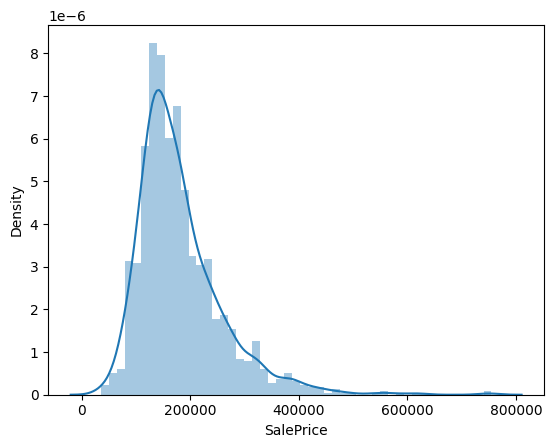

In [8]:
#histogram
sns.distplot(df_train['SalePrice']);

*'Ah! I see you that you use seaborn makeup when you're going out... That's so elegant! I also see that you:*

* *<b>Deviate from the normal distribution.</b>*
* *<b>Have appreciable positive skewness.</b>*
* *<b>Show peakedness.</b>*

*This is getting interesting! 'SalePrice', could you give me your body measures?'*

In [9]:
#skewness and kurtosis
print("Skewness: %f" % df_train['SalePrice'].skew())
print("Kurtosis: %f" % df_train['SalePrice'].kurt())

Skewness: 1.882876
Kurtosis: 6.536282


*'Amazing! If my love calculator is correct, our success probability is 97.834657%. I think we should meet again! Please, keep my number and give me a call if you're free next Friday. See you in a while, crocodile!'*

**'SalePrice', her buddies and her interests**

*It is military wisdom to choose the terrain where you will fight. As soon as 'SalePrice' walked away, we went to Facebook. Yes, now this is getting serious. Notice that this is not stalking. It's just an intense research of an individual, if you know what I mean.*

*According to her profile, we have some common friends. Besides Chuck Norris, we both know 'GrLivArea' and 'TotalBsmtSF'. Moreover, we also have common interests such as 'OverallQual' and 'YearBuilt'. This looks promising!*

*To take the most out of our research, we will start by looking carefully at the profiles of our common friends and later we will focus on our common interests.*

**Relationship with numerical variables**

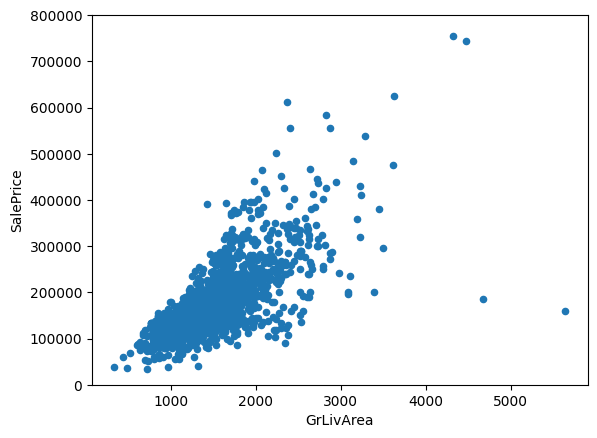

In [10]:
#scatter plot grlivarea/saleprice
var = 'GrLivArea'
data = pd.concat([df_train['SalePrice'], df_train[var]], axis=1)
data.plot.scatter(x=var, y='SalePrice', ylim=(0,800000));

*Hmmm... It seems that 'SalePrice' and 'GrLivArea' are really old friends, with a <b>linear relationship.</b>*

*And what about 'TotalBsmtSF'?*

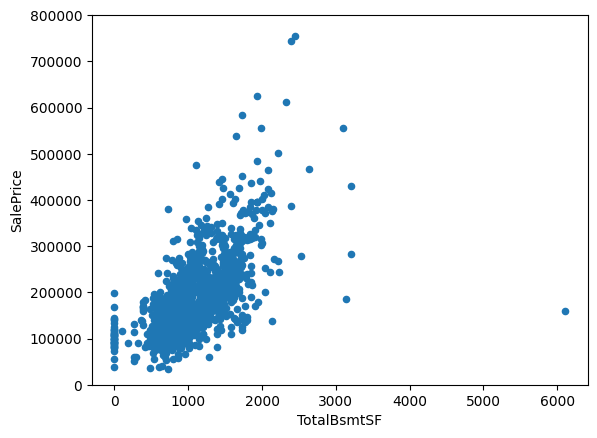

In [11]:
#scatter plot totalbsmtsf/saleprice
var = 'TotalBsmtSF'
data = pd.concat([df_train['SalePrice'], df_train[var]], axis=1)
data.plot.scatter(x=var, y='SalePrice', ylim=(0,800000));

*'TotalBsmtSF' is also a great friend of 'SalePrice' but this seems a much more emotional relationship! Everything is ok and suddenly, in a <b>strong linear (exponential?)</b> reaction, everything changes. Moreover, it's clear that sometimes 'TotalBsmtSF' closes in itself and gives zero credit to 'SalePrice'.*

**Relationship with categorical features**

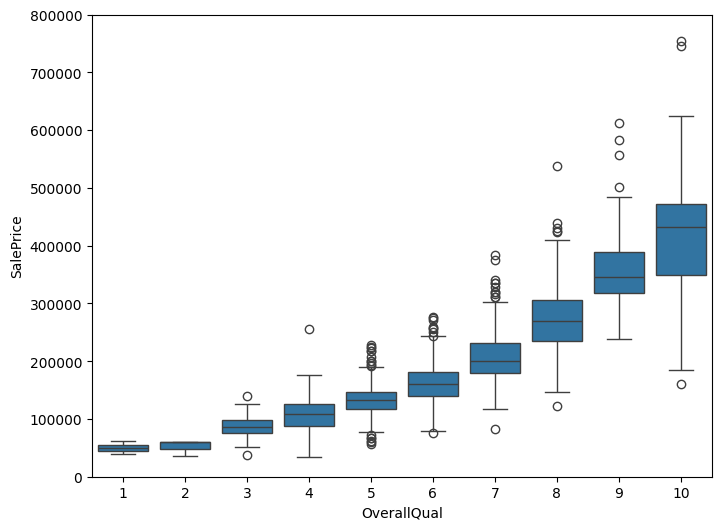

In [12]:
#box plot overallqual/saleprice
var = 'OverallQual'
data = pd.concat([df_train['SalePrice'], df_train[var]], axis=1)
f, ax = plt.subplots(figsize=(8, 6))
fig = sns.boxplot(x=var, y="SalePrice", data=data)
fig.axis(ymin=0, ymax=800000);

*Like all the pretty girls, 'SalePrice' enjoys 'OverallQual'. Note to self: consider whether McDonald's is suitable for the first date.*

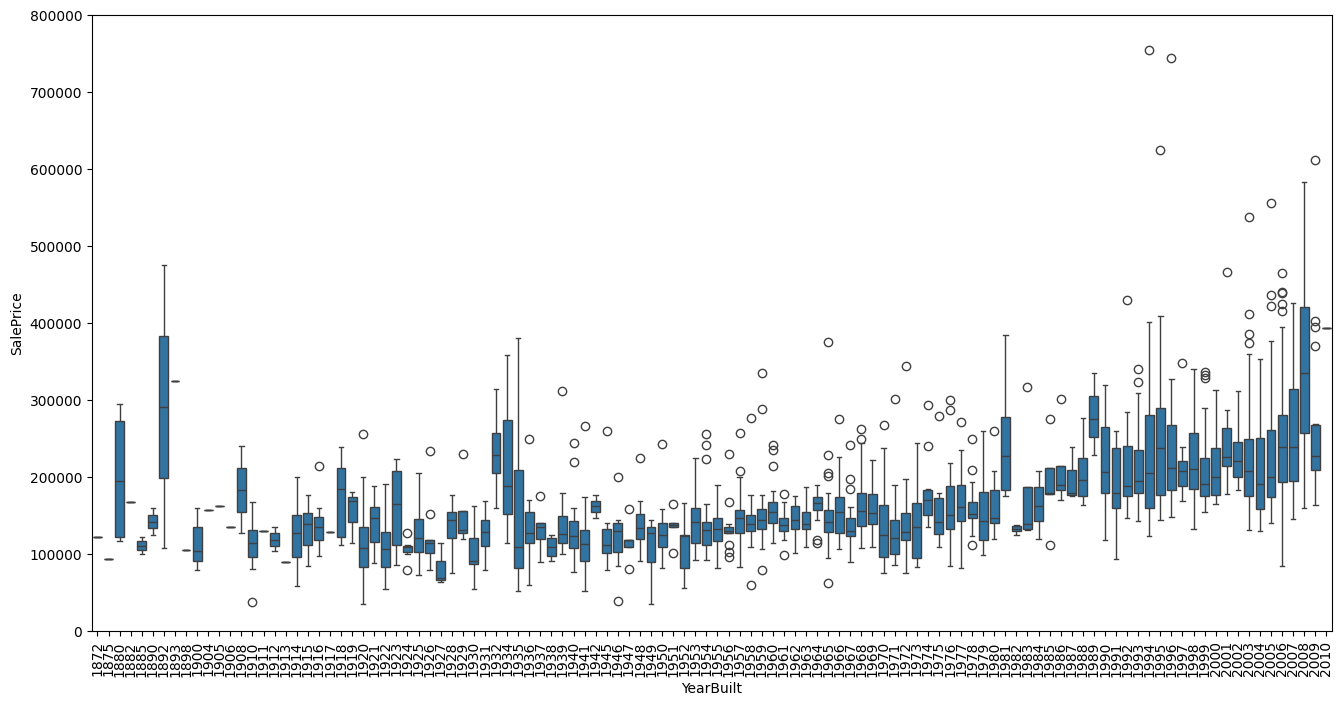

In [13]:
var = 'YearBuilt'
data = pd.concat([df_train['SalePrice'], df_train[var]], axis=1)
f, ax = plt.subplots(figsize=(16, 8))
fig = sns.boxplot(x=var, y="SalePrice", data=data)
fig.axis(ymin=0, ymax=800000);
plt.xticks(rotation=90);

*Although it's not a strong tendency, I'd say that 'SalePrice' is more prone to spend more money in new stuff than in old relics.*

<b>Note</b>: we don't know if 'SalePrice' is in constant prices. Constant prices try to remove the effect of inflation. If 'SalePrice' is not in constant prices, it should be, so than prices are comparable over the years.

**In summary**

Stories aside, we can conclude that:

* 'GrLivArea' and 'TotalBsmtSF' seem to be linearly related with 'SalePrice'. Both relationships are positive, which means that as one variable increases, the other also increases. In the case of 'TotalBsmtSF', we can see that the slope of the linear relationship is particularly high.
* 'OverallQual' and 'YearBuilt' also seem to be related with 'SalePrice'. The relationship seems to be stronger in the case of 'OverallQual', where the box plot shows how sales prices increase with the overall quality.

We just analysed four variables, but there are many other that we should analyse. The trick here seems to be the choice of the right features (feature selection) and not the definition of complex relationships between them (feature engineering).

That said, let's separate the wheat from the chaff.

### **3. Keep calm and work smart**

Until now we just followed our intuition and analysed the variables we thought were important. In spite of our efforts to give an objective character to our analysis, we must say that our starting point was subjective.

As an engineer, I don't feel comfortable with this approach. All my education was about developing a disciplined mind, able to withstand the winds of subjectivity. There's a reason for that. Try to be subjective in structural engineering and you will see physics making things fall down. It can hurt.

So, let's overcome inertia and do a more objective analysis.

**The 'plasma soup'**

'In the very beginning there was nothing except for a plasma soup. What is known of these brief moments in time, at the start of our study of cosmology, is largely conjectural. However, science has devised some sketch of what probably happened, based on what is known about the universe today.' (source: http://umich.edu/~gs265/bigbang.htm)

To explore the universe, we will start with some practical recipes to make sense of our 'plasma soup':
* Correlation matrix (heatmap style).
* 'SalePrice' correlation matrix (zoomed heatmap style).
* Scatter plots between the most correlated variables (move like Jagger style).

Correlation matrix (heatmap style)

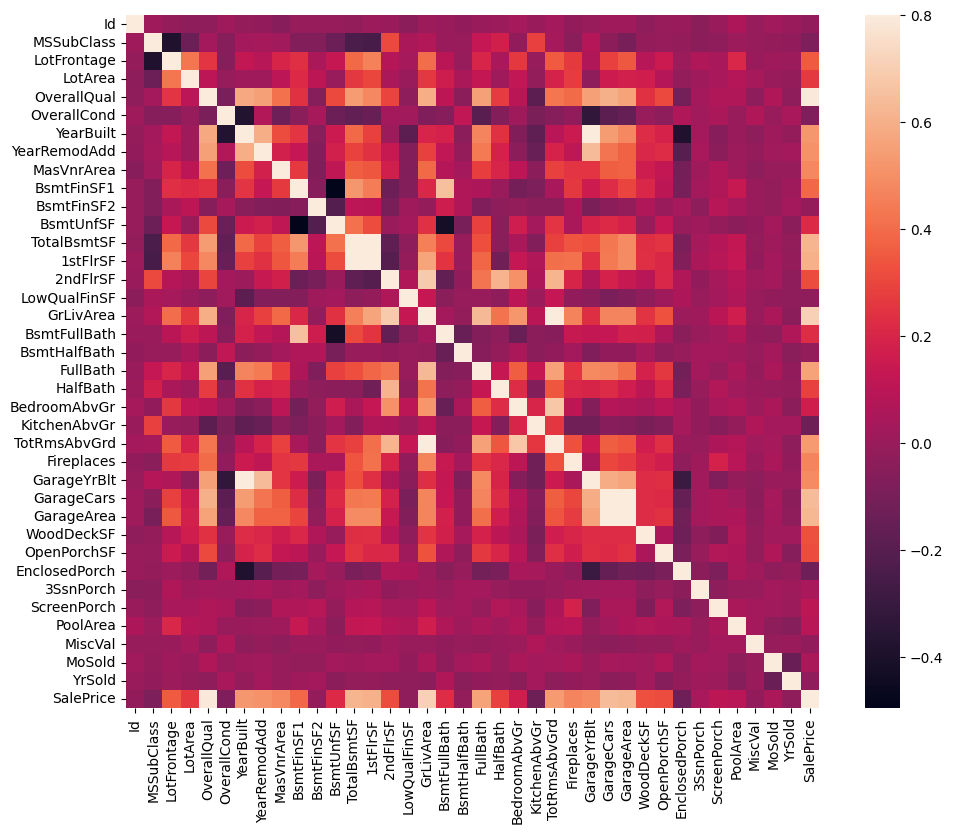

In [14]:
#correlation matrix
corrmat = df_train.corr()
f, ax = plt.subplots(figsize=(12, 9))
sns.heatmap(corrmat, vmax=.8, square=True);

In my opinion, this heatmap is the best way to get a quick overview of our 'plasma soup' and its relationships. (Thank you @seaborn!)

At first sight, there are two red colored squares that get my attention. The first one refers to the 'TotalBsmtSF' and '1stFlrSF' variables, and the second one refers to the 'Garage*X*' variables. Both cases show how significant the correlation is between these variables. Actually, this correlation is so strong that it can indicate a situation of multicollinearity. If we think about these variables, we can conclude that they give almost the same information so multicollinearity really occurs. Heatmaps are great to detect this kind of situations and in problems dominated by feature selection, like ours, they are an essential tool.

Another thing that got my attention was the 'SalePrice' correlations. We can see our well-known 'GrLivArea', 'TotalBsmtSF', and 'OverallQual' saying a big 'Hi!', but we can also see many other variables that should be taken into account. That's what we will do next.

'SalePrice' correlation matrix (zoomed heatmap style)

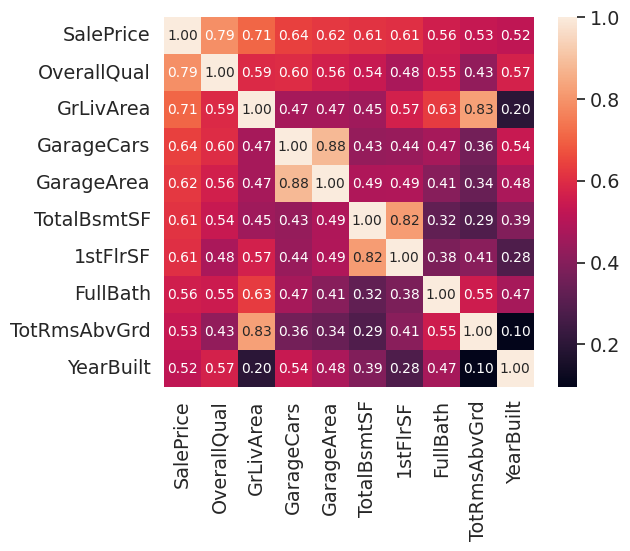

In [15]:
#saleprice correlation matrix
k = 10 #number of variables for heatmap
cols = corrmat.nlargest(k, 'SalePrice')['SalePrice'].index
cm = np.corrcoef(df_train[cols].values.T)
sns.set(font_scale=1.25)
hm = sns.heatmap(cm, cbar=True, annot=True, square=True, fmt='.2f', annot_kws={'size': 10}, yticklabels=cols.values, xticklabels=cols.values)
plt.show()

According to our crystal ball, these are the variables most correlated with 'SalePrice'. My thoughts on this:

* 'OverallQual', 'GrLivArea' and 'TotalBsmtSF' are strongly correlated with 'SalePrice'. Check!
* 'GarageCars' and 'GarageArea' are also some of the most strongly correlated variables. However, as we discussed in the last sub-point, the number of cars that fit into the garage is a consequence of the garage area. 'GarageCars' and 'GarageArea' are like twin brothers. You'll never be able to distinguish them. Therefore, we just need one of these variables in our analysis (we can keep 'GarageCars' since its correlation with 'SalePrice' is higher).
* 'TotalBsmtSF' and '1stFloor' also seem to be twin brothers. We can keep 'TotalBsmtSF' just to say that our first guess was right (re-read 'So... What can we expect?').
* 'FullBath'?? Really?
* 'TotRmsAbvGrd' and 'GrLivArea', twin brothers again. Is this dataset from Chernobyl?
* Ah... 'YearBuilt'... It seems that 'YearBuilt' is slightly correlated with 'SalePrice'. Honestly, it scares me to think about 'YearBuilt' because I start feeling that we should do a little bit of time-series analysis to get this right. I'll leave this as a homework for you.

Let's proceed to the scatter plots.

Scatter plots between 'SalePrice' and correlated variables (move like Jagger style)

Get ready for what you're about to see. I must confess that the first time I saw these scatter plots I was totally blown away! So much information in so short space... It's just amazing. Once more, thank you @seaborn! You make me 'move like Jagger'!

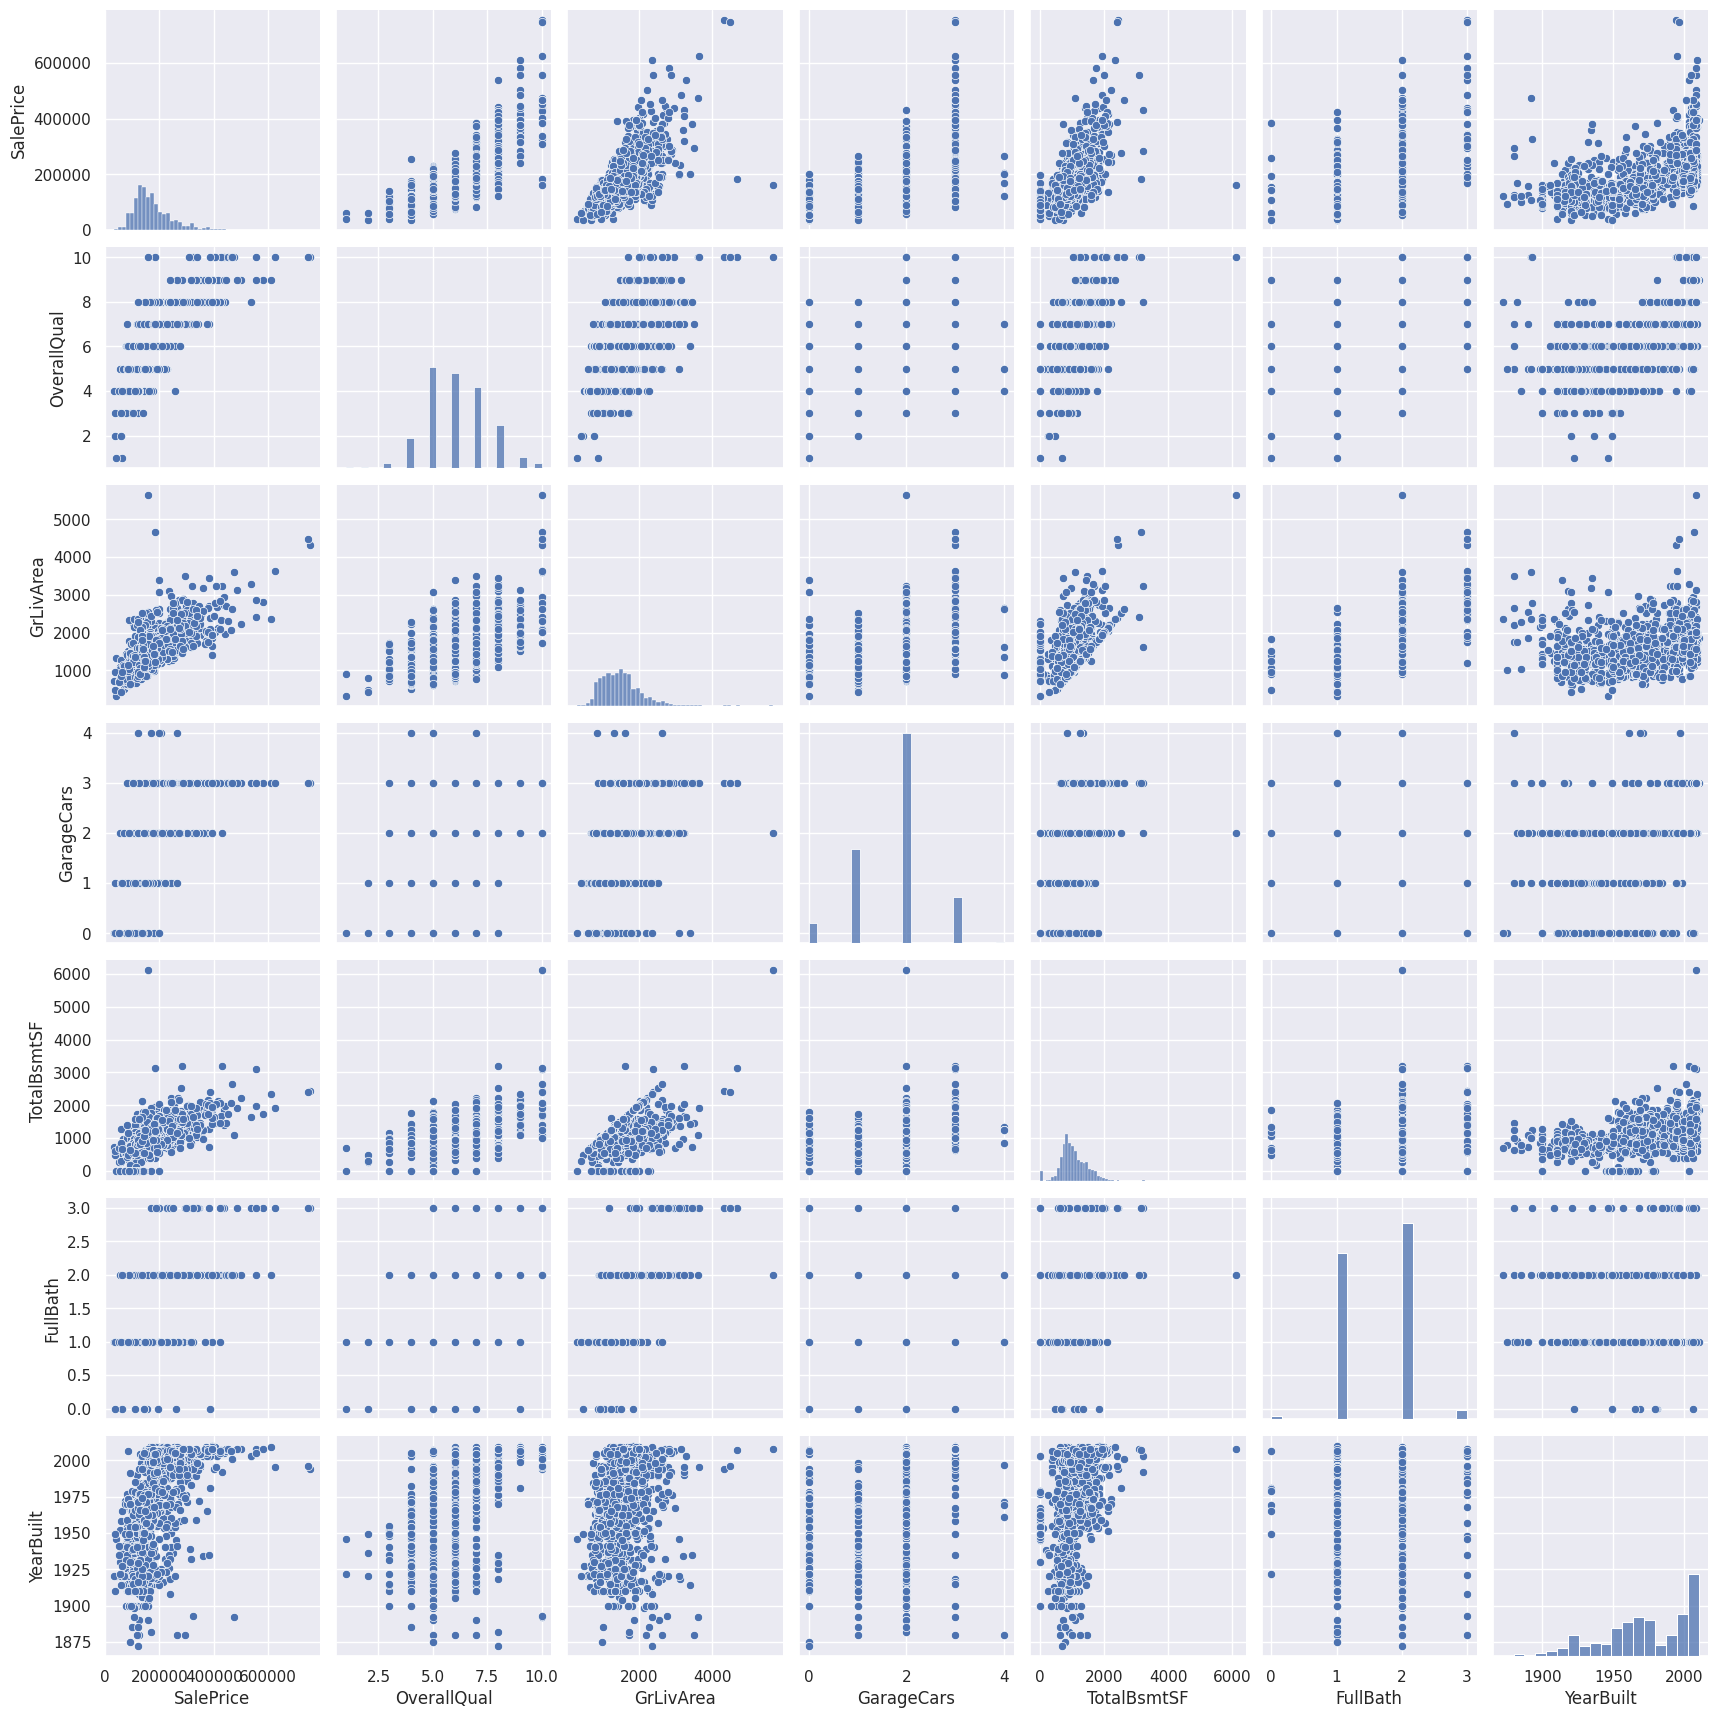

In [16]:
#scatterplot
sns.set()
cols = ['SalePrice', 'OverallQual', 'GrLivArea', 'GarageCars', 'TotalBsmtSF', 'FullBath', 'YearBuilt']
sns.pairplot(df_train[cols], size = 2.5)
plt.show();

Although we already know some of the main figures, this mega scatter plot gives us a reasonable idea about variables relationships.

One of the figures we may find interesting is the one between 'TotalBsmtSF' and 'GrLiveArea'. In this figure we can see the dots drawing a linear line, which almost acts like a border. It totally makes sense that the majority of the dots stay below that line. Basement areas can be equal to the above ground living area, but it is not expected a basement area bigger than the above ground living area (unless you're trying to buy a bunker).

The plot concerning 'SalePrice' and 'YearBuilt' can also make us think. In the bottom of the 'dots cloud', we see what almost appears to be a shy exponential function (be creative). We can also see this same tendency in the upper limit of the 'dots cloud' (be even more creative). Also, notice how the set of dots regarding the last years tend to stay above this limit (I just wanted to say that prices are increasing faster now).

Ok, enough of Rorschach test for now. Let's move forward to what's missing: missing data!

## **2. Data processing**

### **2.1. Missing data**

Important questions when thinking about missing data:

* How prevalent is the missing data?
* Is missing data random or does it have a pattern?

The answer to these questions is important for practical reasons because missing data can imply a reduction of the sample size. This can prevent us from proceeding with the analysis. Moreover, from a substantive perspective, we need to ensure that the missing data process is not biased and hidding an inconvenient truth.

In [17]:
#missing data
total = df_train.isnull().sum().sort_values(ascending=False)
percent = (df_train.isnull().sum()/df_train.isnull().count()).sort_values(ascending=False)
missing_data = pd.concat([total, percent], axis=1, keys=['Total', 'Percent'])
missing_data.head(20)

,Total,Percent
PoolQC,1453,0.995205
MiscFeature,1406,0.963014
Alley,1369,0.937671
Fence,1179,0.807534
FireplaceQu,690,0.472603
LotFrontage,259,0.177397
GarageYrBlt,81,0.055479
GarageCond,81,0.055479
GarageType,81,0.055479
GarageFinish,81,0.055479


Let's analyse this to understand how to handle the missing data.

We'll consider that when more than 15% of the data is missing, we should delete the corresponding variable and pretend it never existed. This means that we will not try any trick to fill the missing data in these cases. According to this, there is a set of variables (e.g. 'PoolQC', 'MiscFeature', 'Alley', etc.) that we should delete. The point is: will we miss this data? I don't think so. None of these variables seem to be very important, since most of them are not aspects in which we think about when buying a house (maybe that's the reason why data is missing?). Moreover, looking closer at the variables, we could say that variables like 'PoolQC', 'MiscFeature' and 'FireplaceQu' are strong candidates for outliers, so we'll be happy to delete them.

In what concerns the remaining cases, we can see that 'Garage*X*' variables have the same number of missing data. I bet missing data refers to the same set of observations (although I will not check it; it's just 5% and we should not spend 20$ in 5$ problems). Since the most important information regarding garages is expressed by 'GarageCars' and considering that we are just talking about 5% of missing data, I'll delete the mentioned 'Garage*X*' variables. The same logic applies to 'Bsmt*X*' variables.

Regarding 'MasVnrArea' and 'MasVnrType', we can consider that these variables are not essential. Furthermore, they have a strong correlation with 'YearBuilt' and 'OverallQual' which are already considered. Thus, we will not lose information if we delete 'MasVnrArea' and 'MasVnrType'.

Finally, we have one missing observation in 'Electrical'. Since it is just one observation, we'll delete this observation and keep the variable.

In summary, to handle missing data, we'll delete all the variables with missing data, except the variable 'Electrical'. In 'Electrical' we'll just delete the observation with missing data.

In [18]:
#dealing with missing data
df_missing_cols = df_train[(missing_data[missing_data['Total'] >= 8]).index]
missing_cols = df_missing_cols.columns
print(missing_cols)

Index(['PoolQC', 'MiscFeature', 'Alley', 'Fence', 'FireplaceQu', 'LotFrontage',
       'GarageYrBlt', 'GarageCond', 'GarageType', 'GarageFinish', 'GarageQual',
       'BsmtFinType2', 'BsmtExposure', 'BsmtQual', 'BsmtCond', 'BsmtFinType1',
       'MasVnrArea', 'MasVnrType'],
      dtype='object')


In [19]:
df_train = df_train.drop(columns=missing_cols)
df_train = df_train.drop(df_train.loc[df_train['Electrical'].isnull()].index)

#just checking that there's no missing data missing...
print(df_train.isnull().sum().max())

0


In [20]:
print("Training set shape: ", df_train.shape)

Training set shape:  (1459, 63)


Check NA

In [21]:
df_train.isna().sum().max()

0

### **2.2. Out liars!**

Outliers is also something that we should be aware of. Why? Because outliers can markedly affect our models and can be a valuable source of information, providing us insights about specific behaviours.

Outliers is a complex subject and it deserves more attention. Here, we'll just do a quick analysis through the standard deviation of 'SalePrice' and a set of scatter plots.

#### **Univariate analysis**

The primary concern here is to establish a threshold that defines an observation as an outlier. To do so, we'll standardize the data. In this context, data standardization means converting data values to have mean of 0 and a standard deviation of 1.

In [22]:
#standardizing data
saleprice_scaled = StandardScaler().fit_transform(df_train['SalePrice'][:,np.newaxis]);
low_range = saleprice_scaled[saleprice_scaled[:,0].argsort()][:10]
high_range= saleprice_scaled[saleprice_scaled[:,0].argsort()][-10:]
print('outer range (low) of the distribution:')
print(low_range)
print('\nouter range (high) of the distribution:')
print(high_range)

outer range (low) of the distribution:
[[-1.83820775]
 [-1.83303414]
 [-1.80044422]
 [-1.78282123]
 [-1.77400974]
 [-1.62295562]
 [-1.6166617 ]
 [-1.58519209]
 [-1.58519209]
 [-1.57269236]]

outer range (high) of the distribution:
[[3.82758058]
 [4.0395221 ]
 [4.49473628]
 [4.70872962]
 [4.728631  ]
 [5.06034585]
 [5.42191907]
 [5.58987866]
 [7.10041987]
 [7.22629831]]


How 'SalePrice' looks with her new clothes:

* Low range values are similar and not too far from 0.
* High range values are far from 0 and the 7.something values are really out of range.

For now, we'll not consider any of these values as an outlier but we should be careful with those two 7.something values.

#### Bivariate analysis

We already know the following scatter plots by heart. However, when we look to things from a new perspective, there's always something to discover. As Alan Kay said, 'a change in perspective is worth 80 IQ points'.

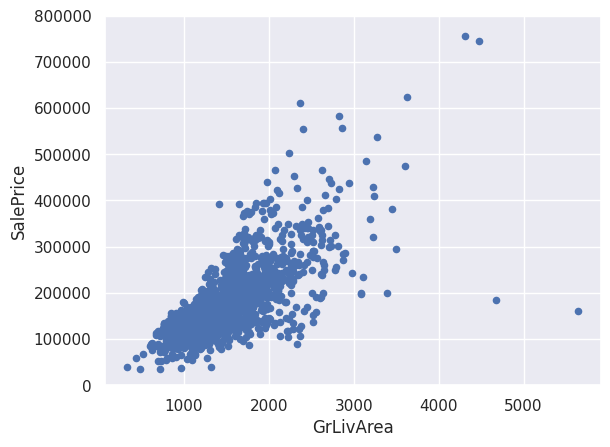

In [23]:
#bivariate analysis saleprice/grlivarea
var = 'GrLivArea'
data = pd.concat([df_train['SalePrice'], df_train[var]], axis=1)
data.plot.scatter(x=var, y='SalePrice', ylim=(0,800000));

What has been revealed:

* The two values with bigger 'GrLivArea' seem strange and they are not following the crowd. We can speculate why this is happening. Maybe they refer to agricultural area and that could explain the low price. I'm not sure about this but I'm quite confident that these two points are not representative of the typical case. Therefore, we'll define them as outliers and delete them.
* The two observations in the top of the plot are those 7.something observations that we said we should be careful about. They look like two special cases, however they seem to be following the trend. For that reason, we will keep them.

In [24]:
#deleting points
filtered_df = df_train[(df_train['GrLivArea'] > 4000) & (df_train['SalePrice'] < 300000)]
df_train = df_train.drop(filtered_df.index)

Check again

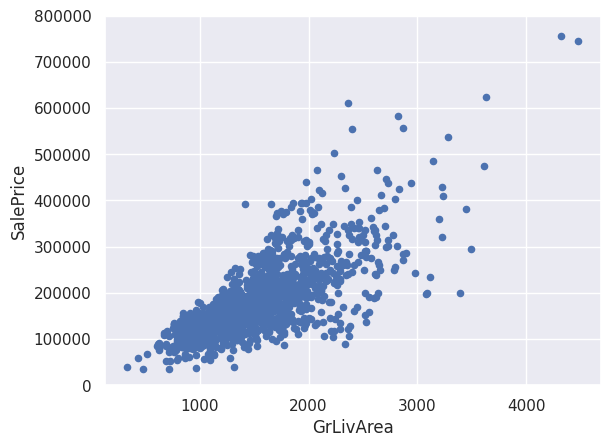

In [25]:
#bivariate analysis saleprice/grlivarea
var = 'GrLivArea'
data = pd.concat([df_train['SalePrice'], df_train[var]], axis=1)
data.plot.scatter(x=var, y='SalePrice', ylim=(0,800000));

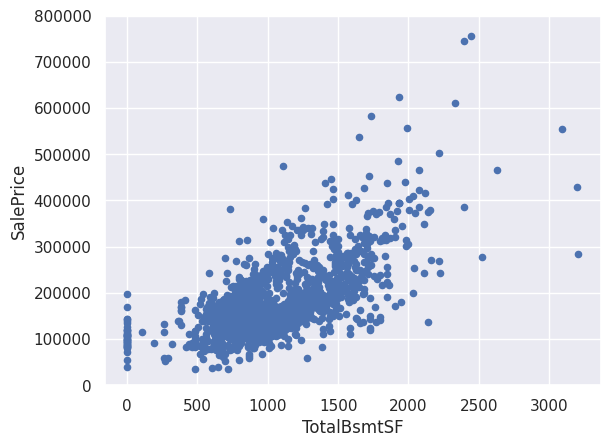

In [26]:
#bivariate analysis saleprice/grlivarea
var = 'TotalBsmtSF'
data = pd.concat([df_train['SalePrice'], df_train[var]], axis=1)
data.plot.scatter(x=var, y='SalePrice', ylim=(0,800000));

We can feel tempted to eliminate some observations (e.g. TotalBsmtSF > 3000) but I suppose it's not worth it. We can live with that, so we'll not do anything.

### **2.3. Getting hard core**

In Ayn Rand's novel, 'Atlas Shrugged', there is an often-repeated question: who is John Galt? A big part of the book is about the quest to discover the answer to this question.

I feel Randian now. Who is 'SalePrice'?

The answer to this question lies in testing for the assumptions underlying the statistical bases for multivariate analysis. We already did some data cleaning and discovered a lot about 'SalePrice'. Now it's time to go deep and understand how 'SalePrice' complies with the statistical assumptions that enables us to apply multivariate techniques.

According to [Hair et al. (2013)](https://amzn.to/2uC3j9p), four assumptions should be tested:

* <b>Normality</b> - When we talk about normality what we mean is that the data should look like a normal distribution. This is important because several statistic tests rely  on this (e.g. t-statistics). In this exercise we'll just check univariate normality for 'SalePrice' (which is a limited approach). Remember that univariate normality doesn't ensure multivariate normality (which is what we would like to have), but it helps. Another detail to take into account is that in big samples (>200 observations) normality is not such an issue. However, if we solve normality, we avoid a lot of other problems (e.g. heteroscedacity) so that's the main reason why we are doing this analysis.

* <b>Homoscedasticity</b> - I just hope I wrote it right. Homoscedasticity refers to the 'assumption that dependent variable(s) exhibit equal levels of variance across the range of predictor variable(s)' [(Hair et al., 2013)](https://amzn.to/2uC3j9p). Homoscedasticity is desirable because we want the error term to be the same across all values of the independent variables.

* <b>Linearity</b>- The most common way to assess linearity is to examine scatter plots and search for linear patterns. If patterns are not linear, it would be worthwhile to explore data transformations. However, we'll not get into this because most of the scatter plots we've seen appear to have linear relationships.

* <b>Absence of correlated errors</b> - Correlated errors, like the definition suggests, happen when one error is correlated to another. For instance, if one positive error makes a negative error systematically, it means that there's a relationship between these variables. This occurs often in time series, where some patterns are time related. We'll also not get into this. However, if you detect something, try to add a variable that can explain the effect you're getting. That's the most common solution for correlated errors.

What do you think Elvis would say about this long explanation? 'A little less conversation, a little more action please'? Probably... By the way, do you know what was Elvis's last great hit?

(...)

The bathroom floor.

#### **In the search for normality**

The point here is to test 'SalePrice' in a very lean way. We'll do this paying attention to:

* <b>Histogram</b> - Kurtosis and skewness.
* <b>Normal probability plot</b> - Data distribution should closely follow the diagonal that represents the normal distribution.

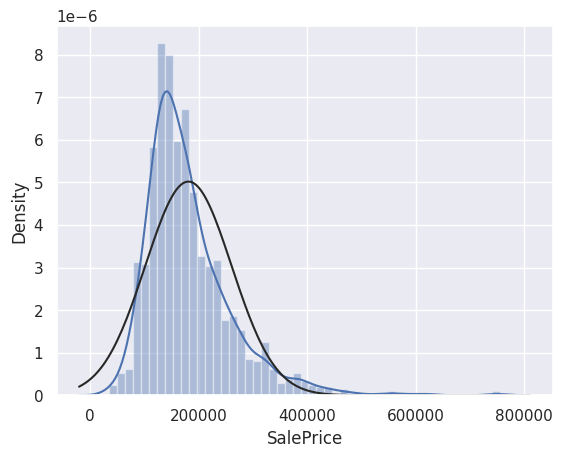

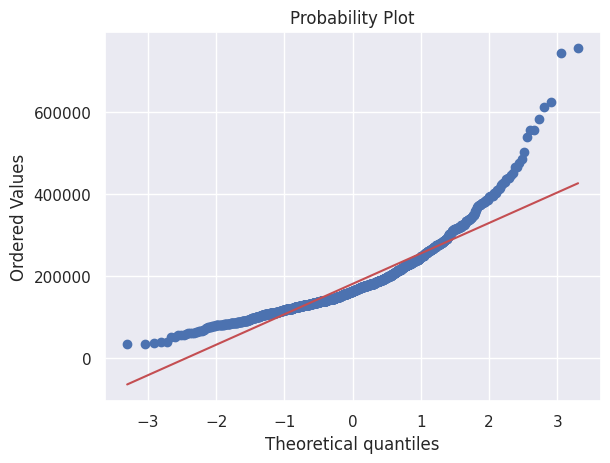

In [27]:
#histogram and normal probability plot
sns.distplot(df_train['SalePrice'], fit=norm);
fig = plt.figure()
res = stats.probplot(df_train['SalePrice'], plot=plt)

Ok, 'SalePrice' is not normal. It shows 'peakedness', positive skewness and does not follow the diagonal line.

But everything's not lost. A simple data transformation can solve the problem. This is one of the awesome things you can learn in statistical books: in case of positive skewness, log transformations usually works well. When I discovered this, I felt like an Hogwarts' student discovering a new cool spell.

*Avada kedavra!*

In [28]:
#applying log transformation
df_train['SalePrice'] = np.log1p(df_train['SalePrice'])

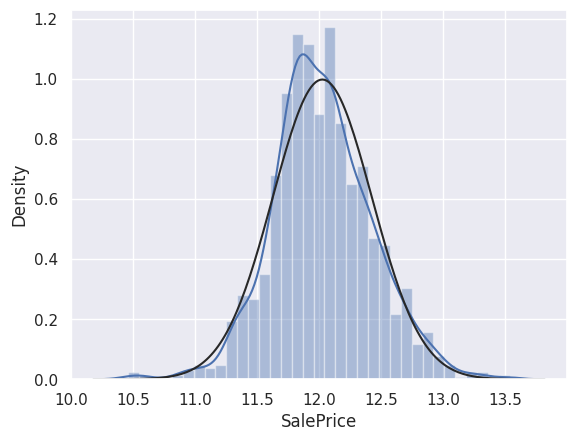

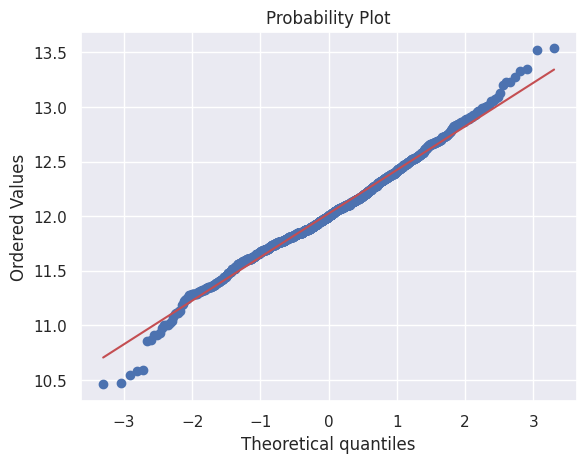

In [29]:
#transformed histogram and normal probability plot
sns.distplot(df_train['SalePrice'], fit=norm);
fig = plt.figure()
res = stats.probplot(df_train['SalePrice'], plot=plt)

Done! Let's check what's going on with 'GrLivArea'.

Do it on the all dataset

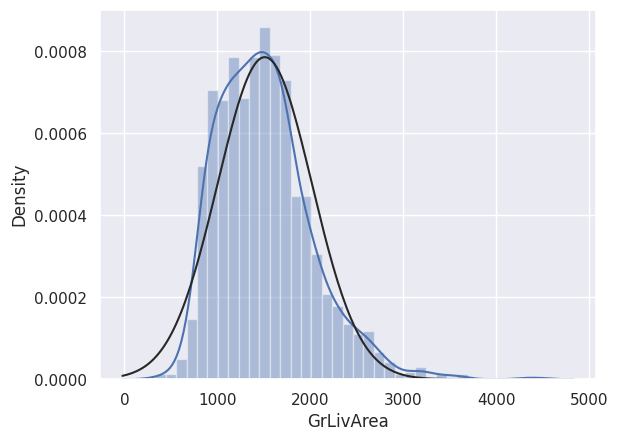

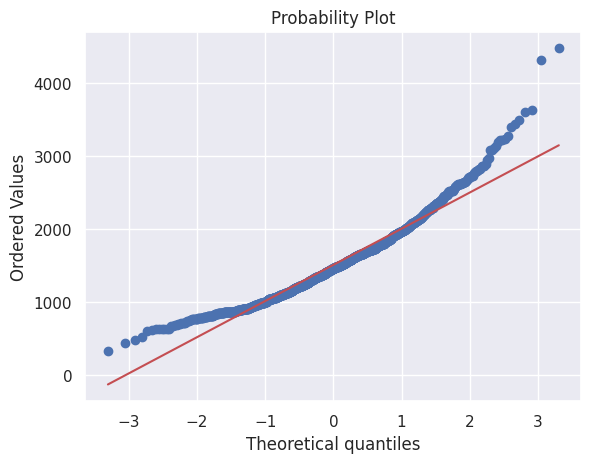

In [30]:
#histogram and normal probability plot
sns.distplot(df_train['GrLivArea'], fit=norm);
fig = plt.figure()
res = stats.probplot(df_train['GrLivArea'], plot=plt)

Tastes like skewness... *Avada kedavra!*

In [31]:
#data transformation
df_train['GrLivArea'] = np.log1p(df_train['GrLivArea'])

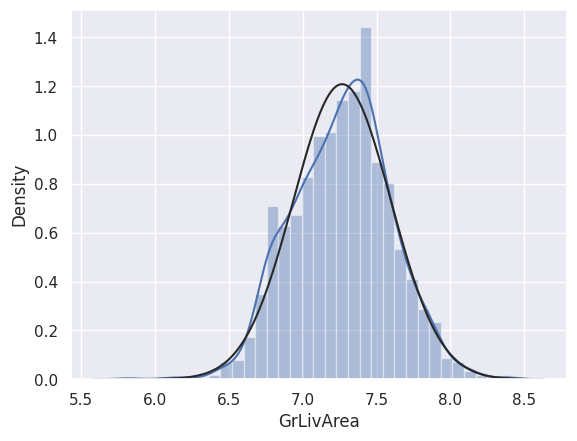

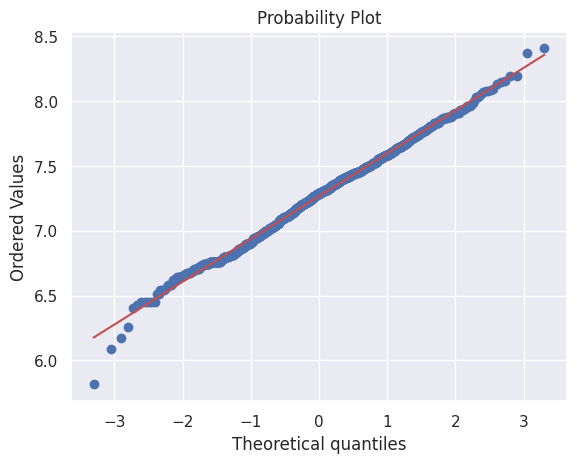

In [32]:
#transformed histogram and normal probability plot
sns.distplot(df_train['GrLivArea'], fit=norm);
fig = plt.figure()
res = stats.probplot(df_train['GrLivArea'], plot=plt)

Next, please...

There is a Na value in TotalBsmtSF col of testing set and it makes the error when we plot it. So we will fill it by 0.0

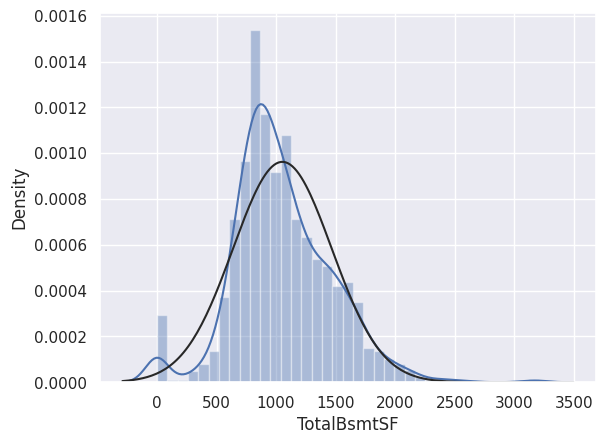

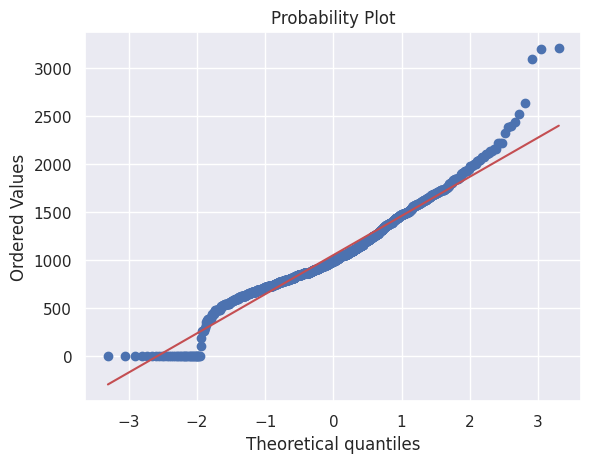

In [33]:
#histogram and normal probability plot
sns.distplot(df_train['TotalBsmtSF'], fit=norm);
fig = plt.figure()
res = stats.probplot(df_train['TotalBsmtSF'], plot=plt)

Ok, now we are dealing with the big boss. What do we have here?

* Something that, in general, presents skewness.
* A significant number of observations with value zero (houses without basement).
* A big problem because the value zero doesn't allow us to do log transformations.

To apply a log transformation here, we'll create a variable that can get the effect of having or not having basement (binary variable). Then, we'll do a log transformation to all the non-zero observations, ignoring those with value zero. This way we can transform data, without losing the effect of having or not basement.

I'm not sure if this approach is correct. It just seemed right to me. That's what I call 'high risk engineering'.

In [34]:
#create column for new variable (one is enough because it's a binary categorical feature)
#if area>0 it gets 1, for area==0 it gets 0
df_train['HasBsmt'] = pd.Series(len(df_train['TotalBsmtSF']), index=df_train.index)
df_train['HasBsmt'] = 0
df_train.loc[df_train['TotalBsmtSF']>0,'HasBsmt'] = 1

In [35]:
#transform data
df_train.loc[df_train['HasBsmt']==1,'TotalBsmtSF'] = np.log1p(df_train['TotalBsmtSF'])

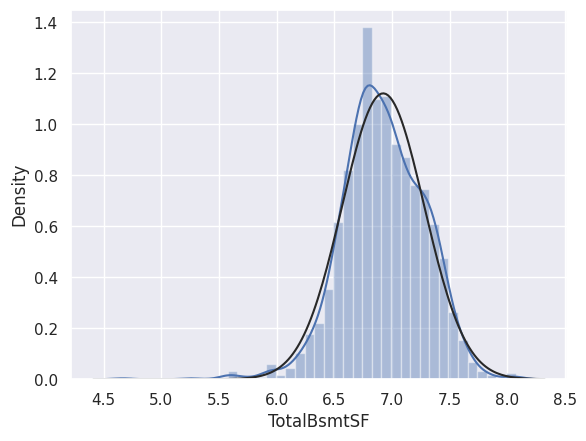

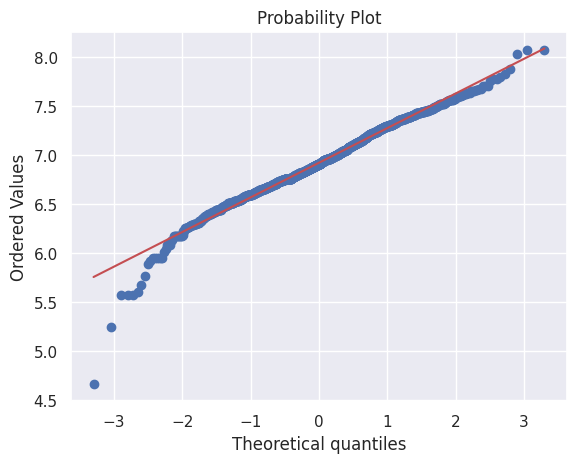

In [36]:
#histogram and normal probability plot
sns.distplot(df_train[df_train['TotalBsmtSF']>0]['TotalBsmtSF'], fit=norm);
fig = plt.figure()
res = stats.probplot(df_train[df_train['TotalBsmtSF']>0]['TotalBsmtSF'], plot=plt)

#### In the search for writing 'homoscedasticity' right at the first attempt

The best approach to test homoscedasticity for two metric variables is graphically. Departures from an equal dispersion are shown by such shapes as cones (small dispersion at one side of the graph, large dispersion at the opposite side) or diamonds (a large number of points at the center of the distribution).

Starting by 'SalePrice' and 'GrLivArea'...

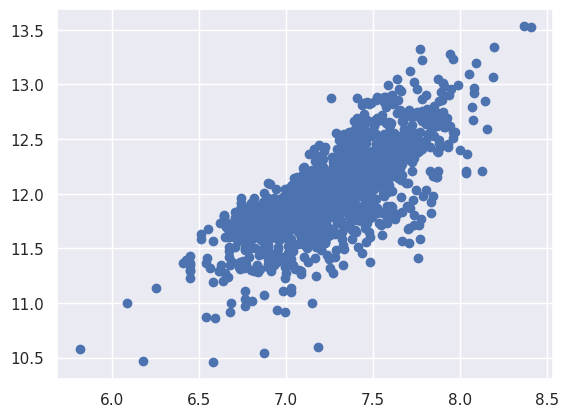

In [37]:
#scatter plot
plt.scatter(df_train['GrLivArea'], df_train['SalePrice']);

Older versions of this scatter plot (previous to log transformations), had a conic shape (go back and check 'Scatter plots between 'SalePrice' and correlated variables (move like Jagger style)'). As you can see, the current scatter plot doesn't have a conic shape anymore. That's the power of normality! Just by ensuring normality in some variables, we solved the homoscedasticity problem.

Now let's check 'SalePrice' with 'TotalBsmtSF'.

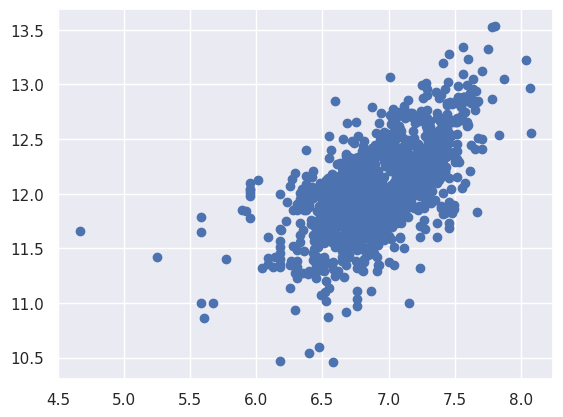

In [38]:
#scatter plot
plt.scatter(df_train[df_train['TotalBsmtSF']>0]['TotalBsmtSF'], df_train[df_train['TotalBsmtSF']>0]['SalePrice']);

We can say that, in general, 'SalePrice' exhibit equal levels of variance across the range of 'TotalBsmtSF'. Cool!

Adding one more important feature

Since area related features are very important to determine house prices, we add one more feature which is the total area of basement, first and second floor areas of each house

In [39]:
# Adding total sqfootage feature
df_train['TotalSF'] = df_train['TotalBsmtSF'] + df_train['1stFlrSF'] + df_train['2ndFlrSF']

#### **Last but not the least, Scale variables**

Easy mode.

Label Encoding the Categorical Variables

In [40]:
#convert categorical variable into numerical
from sklearn.preprocessing import StandardScaler, LabelEncoder
LE = LabelEncoder()
cat_cols = df_train.select_dtypes(include="object").columns
cat_cols

Index(['MSZoning', 'Street', 'LotShape', 'LandContour', 'Utilities',
       'LotConfig', 'LandSlope', 'Neighborhood', 'Condition1', 'Condition2',
       'BldgType', 'HouseStyle', 'RoofStyle', 'RoofMatl', 'Exterior1st',
       'Exterior2nd', 'ExterQual', 'ExterCond', 'Foundation', 'Heating',
       'HeatingQC', 'CentralAir', 'Electrical', 'KitchenQual', 'Functional',
       'PavedDrive', 'SaleType', 'SaleCondition'],
      dtype='object')

In [41]:
for col in cat_cols:
    df_train[col] = LE.fit_transform(df_train[col])

df_train.head()

,Id,MSSubClass,MSZoning,LotArea,Street,LotShape,LandContour,Utilities,LotConfig,LandSlope,...,ScreenPorch,PoolArea,MiscVal,MoSold,YrSold,SaleType,SaleCondition,SalePrice,HasBsmt,TotalSF
0,1,60,3,8450,1,3,3,0,4,0,...,0,0,0,2,2008,8,4,12.247699,1,1716.753438
1,2,20,3,9600,1,3,3,0,2,0,...,0,0,0,5,2007,8,4,12.109016,1,1269.141245
2,3,60,3,11250,1,0,3,0,4,0,...,0,0,0,9,2008,8,4,12.317171,1,1792.825460
3,4,70,3,9550,1,0,3,0,0,0,...,0,0,0,2,2006,8,0,11.849405,1,1723.629363
4,5,60,3,14260,1,0,3,0,2,0,...,0,0,0,12,2008,8,4,12.429220,1,2205.044033


Before scaling the data into Training set and testing set, we need to shuffle the data

In [42]:
df_train = df_train.sample(frac=1).reset_index(drop=True)

Dropping Id, since it isn’t of any significance

In [43]:
df_train.drop(['Id'], axis=1, inplace=True)
df_train.shape

(1457, 64)

Scale the values using StandardScaler

In [44]:
sc_df = StandardScaler()
X = sc_df.fit_transform(df_train.drop(['SalePrice'], axis=1))

In [45]:
y = np.array(df_train['SalePrice'])

In [46]:
print("X_train:{0}".format(X.shape))
print("Y_train:{0}".format(y.shape))

X_train:(1457, 63)
Y_train:(1457,)


Split the data

In [47]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, random_state=42)

In [48]:
print("X_train:{0}".format(X_train.shape))
print("Y_train:{0}".format(y_train.shape))
print("X_test:{0}".format(X_test.shape))
print("Y_test:{0}".format(y_test.shape))

X_train:(1092, 63)
Y_train:(1092,)
X_test:(365, 63)
Y_test:(365,)


In [49]:
X_train[:2]

array([[ 0.07378257, -0.04557889,  0.19875543,  0.06430458,  0.75019021,
         0.31250729, -0.02620712,  0.60447045, -0.22596024, -1.20690024,
        -0.03561678, -0.02703117, -0.41218634,  1.03073175,  0.65787705,
        -0.51787463,  0.9876002 ,  0.78421636, -0.48999664, -0.12721313,
         0.74286152,  0.75144436, -0.78914689,  0.36463203,  0.83706077,
         0.52417535, -0.28897464, -0.65425876,  0.08939144, -0.12317457,
        -0.88527591,  0.26410295,  0.3027431 , -0.57847774,  1.26434551,
        -0.12036724,  0.76114142,  1.11319822, -0.24132352,  0.79398955,
         1.23075947,  0.16395217, -0.21168091, -0.41539044, -0.31602253,
         0.25625829, -0.95285453,  0.31327677,  0.70630863,  0.29006798,
        -0.75054135, -0.01955971, -0.35974246, -0.11646062, -0.27050673,
        -0.06373063, -0.08777874, -0.11998518,  0.8909727 ,  0.3126369 ,
         0.21014607,  0.16141976,  0.66609267],
       [ 1.49138093, -3.2078856 , -0.5417727 ,  0.06430458, -1.37908344,
   

In [50]:
y_train[:2]

array([12.34583894, 12.70351207])

# **Modelling**

Here is main part of this kernel. We will implement the Linear Regression from scatch and compare the result with Sklearn and Tensorflow

In [51]:
class LinearRegression():
    def __init__(self, W_init, b_init, learning_rate=0.01, num_iterations=1000):
        self.learning_rate = learning_rate
        self.num_iterations = num_iterations
        self.W = W_init
        self.b = b_init

    def predict(self, X):
        predicts = np.dot(X, self.W.T) + self.b

        return predicts

    def cost(self, y, y_predict):
        m = y.shape[0]

        error = np.sum(np.square(y - y_predict))/(2*m)

        return error

    # Batch gradient
    def gradient(self, X, y, y_predict):
        m = X.shape[0]

        d_w = np.sum(np.dot(y_predict - y, X), axis=0)/m
        d_b = np.sum(y_predict - y)/m

        return d_w, d_b

    def update_grad(self, d_w, d_b):
        W = self.W
        b = self.b

        W -= self.learning_rate * d_w
        b -= self.learning_rate * d_b

        return W, b

    def fit(self, X, y):
        costs = []
        for i in range(self.num_iterations):
            #print('------------------------ Interation: {0} -------------------'.format(i))
            y_predict = self.predict(X)
            cost = self.cost(y, y_predict)
            costs.append(cost)
            #print('------ ERROR: {0} ------'.format(cost))
            d_w, d_b = self.gradient(X, y, y_predict)
            self.W, self.b = self.update_grad(d_w, d_b)

        return costs

**Training**

In [52]:
m, n = X_train.shape
W_init = np.zeros(n)
b_init = 0

lr = LinearRegression(W_init, b_init, learning_rate=0.01, num_iterations=200)

In [53]:
errors = lr.fit(X_train, y_train)

Plotting our loss curve

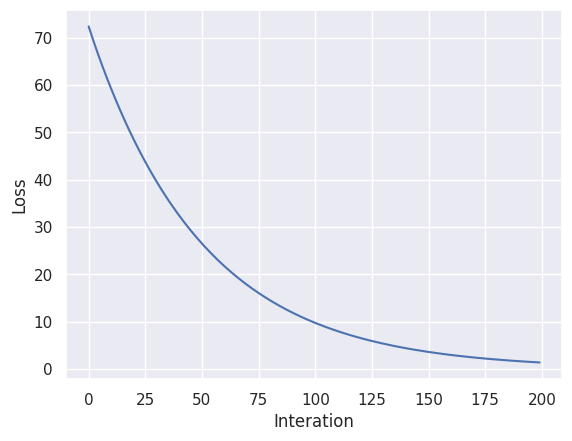

In [54]:
import matplotlib.pyplot as plt

plt.plot([i for i in range(len(errors))], errors)
plt.xlabel("Interation")
plt.ylabel("Loss")
plt.show()

In [55]:
errors[-1]

1.353092276244119

**Testing**

In [56]:
y_test_hat = lr.predict(X_test)
error_test = lr.cost(y_test, y_test_hat)

In [57]:
error_test

1.343072753795956

Compare the same problem using Sklearn’s inbuilt function:

In [58]:
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error
import numpy as np

# Assuming X_train, y_train, X_test, y_test are your training and test data
# Train a linear regression model
model = LinearRegression()
model.fit(X_train, y_train)

# Predict on the test data
y_pred = model.predict(X_test)

# Calculate RMSE
mse = mean_squared_error(y_test, y_pred)

print("Mean Squared Error:", mse)

Root Mean Squared Error: 0.11149251895053641


Compare the same problem using Tensorflow’s inbuilt function:

In [60]:
import tensorflow as tf

# Assuming X_train, y_train, X_test, y_test are your training and test data
num_features = X_train.shape[1]

# Reshape y_train and y_test to have shape (?, 1)
y_train_reshaped = y_train.reshape(-1, 1)
y_test_reshaped = y_test.reshape(-1, 1)

# Define linear regression model
model = tf.keras.Sequential([
    tf.keras.layers.Input(shape=(num_features,)),
    tf.keras.layers.Dense(1)
])

# Compile the model with batch gradient descent
optimizer = tf.keras.optimizers.SGD(learning_rate=0.01)
model.compile(optimizer=optimizer, loss='mean_squared_error')

# Train the model with batch gradient descent
history = model.fit(X_train, y_train_reshaped, epochs=200, batch_size=len(X_train), verbose=1)

# After training, make predictions on the test data
y_pred = model.predict(X_test)

# Calculate RMSE
mse = mean_squared_error(y_test_reshaped, y_pred)
print("Root Mean Squared Error:", mse)

Epoch 1/200
1/1 [==============================] - 0s 388ms/step - loss: 145.3984
Epoch 2/200
1/1 [==============================] - 0s 11ms/step - loss: 139.6100
Epoch 3/200
1/1 [==============================] - 0s 13ms/step - loss: 134.0543
Epoch 4/200
1/1 [==============================] - 0s 10ms/step - loss: 128.7217
Epoch 5/200
1/1 [==============================] - 0s 11ms/step - loss: 123.6033
Epoch 6/200
1/1 [==============================] - 0s 11ms/step - loss: 118.6903
Epoch 7/200
1/1 [==============================] - 0s 10ms/step - loss: 113.9744
Epoch 8/200
1/1 [==============================] - 0s 10ms/step - loss: 109.4477
Epoch 9/200
1/1 [==============================] - 0s 11ms/step - loss: 105.1024
Epoch 10/200
1/1 [==============================] - 0s 13ms/step - loss: 100.9313
Epoch 11/200
1/1 [==============================] - 0s 11ms/step - loss: 96.9272
Epoch 12/200
1/1 [==============================] - 0s 12ms/step - loss: 93.0835
Epoch 13/200
1/1 [========

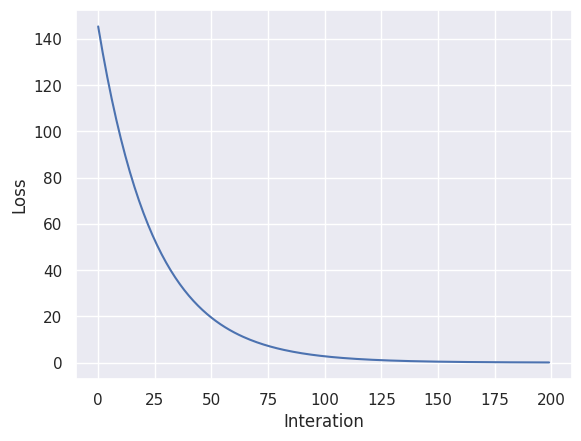

In [62]:
import matplotlib.pyplot as plt

plt.plot(history.history['loss'])
plt.xlabel("Interation")
plt.ylabel("Loss")
plt.show()

# **Conclusion**

* Comparing our model with Tensorflow's and Sklearn's LinearRegression, we see that the MSE of our is larger, but It seems like our implementation is fine. But we need some update to reach the result of Tensorflow's and Sklearn's LinearRegression

# <b>References</b>
* [Comprehensive data exploration with Python](https://www.kaggle.com/code/pmarcelino/comprehensive-data-exploration-with-python)
* [House Price Prediction using Linear Regression from Scratch](https://medium.com/analytics-vidhya/house-price-prediction-using-linear-regression-from-scratch-b2b48fd73689)